# Load dependencies

In [2]:
project_name = 'kornet'
import os
#get current working directory
cwd = os.getcwd()
git_dir = cwd.split(project_name)[0] + project_name
import sys

#add git_dir to path
sys.path.append(git_dir)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from glob import glob as glob
import pdb
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_dir = f'{git_dir}/data'
results_dir = f'{git_dir}/results'
fig_dir = f'{git_dir}/figures'


sub_info = pd.read_csv(f'{data_dir}/sub_info.csv' )
#remove subjects with NaNs in code field
#sub_info = sub_info[~sub_info['code'].isna()]
#remove subjects with 1 in exclude field
sub_info = sub_info[sub_info['exclude'] != 1]


benchmark_models = ['vonenet_r_ecoset','vonenet_r_stylized-ecoset','vonenet_ff_ecoset','vonenet_ff_stylized-ecoset',
    'vonecornet_s','cornet_s','voneresnet', 'vit','convnext','resnet50','resnext50','alexnet','vgg19', 'ShapeNet','SayCam']

benchmark_models = ['vonenet_r_ecoset','vonenet_r_stylized-ecoset','vonenet_ff_ecoset','vonenet_ff_stylized-ecoset', 'ShapeNet','SayCam', 'vit','convnext']
conds = ['complete', 'perturbed','deleted']
model_conds = ['Outline','Pert','IC']
durations = [.3,.25, .2,.15,.1]
duration_labels = [300, 250, 200, 150, 100]
speed = ['intro','slow','slow','fast','fast']

age_groups = ['3yrold','4yrold','5yrold','adult']
#reverse list


#convert to hex
colors = sns.color_palette("deep")

all_colors_hex = [f'#{int(255*color[0]):02x}{int(255*color[1]):02x}{int(255*color[2]):02x}' for color in colors]


### Sumarize group info

In [3]:
#summarize sub info
print(f'Number of subjects: {len(sub_info)}')
print(f'Number of subjects per age group:')
print(sub_info.groupby('age_group').size())
print(f'Number of subjects per condition:')
print(sub_info.groupby('cond').size())

print(f'Number of subjects per sex:')
print(sub_info.groupby('sex').size())

#mean age and range
print(f'Mean age: {sub_info.age.mean()}')
print(f'Age range: {sub_info.age.min()} - {sub_info.age.max()}')

Number of subjects: 128
Number of subjects per age group:
age_group
3    38
4    45
5    45
dtype: int64
Number of subjects per condition:
cond
1    43
2    42
3    43
dtype: int64
Number of subjects per sex:
sex
F    65
M    63
dtype: int64
Mean age: 4.61453125
Age range: 3.05 - 5.95


### Create child summary files

In [4]:


sub_summary = pd.DataFrame(columns = ['sub','sex','age','cond','duration','acc','rt','imputed','top_speed'])

for sub in sub_info['sub']:

    sub_cond = sub_info[sub_info['sub']==sub]['cond'].values[0] -1 #subtract 1 because conditions are 1 2 3
    sub_file = glob(f'{data_dir}/{conds[sub_cond]}/{sub}_*.csv')
    #check if subfile is not empty
    if len(sub_file) != 0:
        to_impute = False #flag to check whether some data was imputed
        sub_file = sub_file[0]
    
        temp_summary = pd.DataFrame(columns = sub_summary.columns)
        #glob a file from cond with sub number
        

        #load sub data
        sub_data = pd.read_csv(sub_file)

        #remove practice trials
        sub_data = sub_data[sub_data['pracTrials.ran']!=1]
        acc = sub_data.groupby(['Duration'])['resp.corr'].mean().reset_index()
        rt = sub_data[sub_data['resp.corr']==1].groupby(['Duration'])['resp.rt'].mean().reset_index()
        sem = sub_data.groupby(['Duration'])['resp.corr'].sem()
        sem = sem.reset_index()
        


        temp_summary['acc'] = acc['resp.corr']
        temp_summary['rt'] = rt['resp.rt']
        temp_summary['duration']= acc['Duration']
        temp_summary['imputed'] = 0

        temp_summary['sub'] = sub
        temp_summary['cond'] = conds[sub_cond]
        temp_summary['age'] = sub_info[sub_info['sub']==sub]['age'].values[0]
        temp_summary['age_group'] = np.floor(sub_info[sub_info['sub']==sub]['age'].values[0]).astype(str)[:-2] + 'yrold'
        temp_summary['sex'] = sub_info[sub_info['sub']==sub]['sex'].values[0]

        #find fastest speed
        #this is reverse coded as duration
        top_speed = .3 - np.min(temp_summary['duration'])
        


        
        #loop through durations and check if there is data for each duration
        for dur in durations:
            
            if dur not in temp_summary['duration'].values:
                #add row for duration and fill with .5 - sem
                sem = sub_data['resp.corr'].sem()

                #add new row to temp_summary with .5 - sem for acc and np.nan for rt, all other values the same               
                temp_summary = pd.concat([temp_summary, 
                                         pd.DataFrame({'sub':[sub], 'cond':[conds[sub_cond]], 'age':[sub_info[sub_info['sub']==sub]['age'].values[0]],'age_group':[temp_summary['age_group'].values[0]],'sex': [sub_info[sub_info['sub']==sub]['sex'].values[0]],
                                                       'duration':[dur], 'acc':[.5 - sem], 'rt':[np.nan], 'imputed':[1]})])

                to_impute = True
        

        if to_impute == True:
            temp_summary['imputed'] = 1


        temp_summary['top_speed'] = top_speed
                   
        

        #check if acc for .3 duration is over .5
        #if temp_summary[temp_summary['duration']==.3]['acc'].values[0] > (.5+ sem['resp.corr'][sem['Duration'] == .30].values[0]):
        sub_summary = pd.concat([sub_summary, temp_summary], axis = 0)

        
        


    else:
        print(f'no file for {sub}')


#append column for speed
for i in range(len(durations)):
    sub_summary.loc[sub_summary['duration']==durations[i],'speed'] = speed[i]
    
    
#save long format    
sub_summary.to_csv(f'{results_dir}/group_data/sub_summary_long.csv', index = False)






no file for 6096
no file for 6123


In [5]:
#create new sub_info with only subjects that have data
sub_info = sub_info[sub_info['sub'].isin(sub_summary['sub'])]

#summarize sub info
print(f'Number of subjects: {len(sub_info)}')
print(f'Number of subjects per age group:')
print(sub_info.groupby('age_group').size())
print(f'Number of subjects per condition:')
print(sub_info.groupby('cond').size())

print(f'Number of subjects per sex:')
print(sub_info.groupby('sex').size())

#mean age and range
print(f'Mean age: {sub_info.age.mean()}')
print(f'Age range: {sub_info.age.min()} - {sub_info.age.max()}')

Number of subjects: 126
Number of subjects per age group:
age_group
3    37
4    45
5    44
dtype: int64
Number of subjects per condition:
cond
1    42
2    42
3    42
dtype: int64
Number of subjects per sex:
sex
F    64
M    62
dtype: int64
Mean age: 4.617301587301587
Age range: 3.05 - 5.95


In [6]:
'''Convert to wide format for analysis'''

sub_summary_wide = sub_summary



#Remove any durations over .35
sub_summary_wide = sub_summary_wide[sub_summary_wide['duration']<=.3]

#calculate sd across all kids
sd = sub_summary_wide['acc'].std() 


#first convert duration to string
sub_summary_wide['duration'] = sub_summary_wide['duration'].astype(str)
#convert age_group to string
sub_summary_wide['age_group'] = sub_summary_wide['age_group'].astype(str)
#convert imputed to string
sub_summary_wide['imputed'] = sub_summary_wide['imputed'].astype(str)
#convert top_speed to string
sub_summary_wide['top_speed'] = np.round(sub_summary_wide['top_speed'],2).astype(str)


sub_summary_wide = sub_summary_wide.groupby(['sub','cond','age','age_group','duration','imputed','top_speed'])['acc'].mean().reset_index()
sub_summary_wide = sub_summary_wide.pivot_table(index = ['sub','cond','age','age_group','imputed','top_speed'], columns = 'duration', values = 'acc').reset_index()

#save wide format
sub_summary_wide.to_csv(f'{results_dir}/group_data/sub_summary_wide.csv', index = False)
#loop through and save seperate files for complete, perturbed, and deleted
for cond in conds:
    temp = sub_summary_wide[sub_summary_wide['cond']==cond]
    temp.to_csv(f'{results_dir}/group_data/sub_summary_{cond}.csv', index = False)

### Creat adult summary

In [7]:
#glob csv files from adult fodler 
adult_files = glob(f'{data_dir}/adult/*.csv')

sub_summary = pd.DataFrame(columns = ['sub','sex','age','cond','duration','acc','rt','imputed','top_speed'])

for file in adult_files:
    to_impute = False
    sub = file.split('/')[-1].split('_')[0]
    cond = file.split('/')[-1].split('_')[3]

    sub_data = pd.read_csv(file)
    sub_data = sub_data[sub_data['pracTrials.ran']!=1]
    acc = sub_data.groupby(['Duration'])['resp.corr'].mean().reset_index()
    rt = sub_data[sub_data['resp.corr']==1].groupby(['Duration'])['resp.rt'].mean().reset_index()
    sem = sub_data.groupby(['Duration'])['resp.corr'].sem()
    sem = sem.reset_index()


    temp_summary = pd.DataFrame(columns = sub_summary.columns)
    temp_summary['acc'] = acc['resp.corr']
    temp_summary['rt'] = rt['resp.rt']
    temp_summary['duration']= acc['Duration']
    temp_summary['imputed'] = 0

    temp_summary['sub'] = sub
    temp_summary['cond'] = cond
    temp_summary['age'] = 30

    temp_summary['age_group'] = 'adult'

    top_speed = .3 - np.min(temp_summary['duration'])

    #loop through durations and check if there is data for each duration
    for dur in durations:
        
        if dur not in temp_summary['duration'].values:
            #add row for duration and fill with .5 - sem
            sem = sub_data['resp.corr'].sem()

            #add new row to temp_summary with .5 - sem for acc and np.nan for rt, all other values the same               
            temp_summary = pd.concat([temp_summary, 
                                        pd.DataFrame({'sub':[sub], 'cond':[conds[sub_cond]], 'age':[sub_info[sub_info['sub']==sub]['age'].values[0]],'age_group':[temp_summary['age_group'].values[0]],'sex': [sub_info[sub_info['sub']==sub]['sex'].values[0]],
                                                    'duration':[dur], 'acc':[.5 - sem], 'rt':[np.nan], 'imputed':[1]})])

            to_impute = True
    

    if to_impute == True:
        temp_summary['imputed'] = 1


    temp_summary['top_speed'] = top_speed
                
    

    #check if acc for .3 duration is over .5
    #if temp_summary[temp_summary['duration']==.3]['acc'].values[0] > (.5+ sem['resp.corr'][sem['Duration'] == .30].values[0]):
    sub_summary = pd.concat([sub_summary, temp_summary], axis = 0)

#append column for speed
for i in range(len(durations)):
    sub_summary.loc[sub_summary['duration']==durations[i],'speed'] = speed[i]


#save 
sub_summary.to_csv(f'{results_dir}/group_data/sub_summary_adult.csv', index = False)
    





In [8]:
#count number of unique subs in each condition
print(sub_summary.groupby('cond').sub.nunique())

cond
complete     10
deleted      10
perturbed     9
Name: sub, dtype: int64


### Combine child and adult data

In [10]:
'''Create long version of child and adult summary'''

#load data
child_summary = pd.read_csv(f'{results_dir}/group_data/sub_summary_long.csv')

#load adult data
adult_summary = pd.read_csv(f'{results_dir}/group_data/sub_summary_adult.csv')

#append adult data to sub_summary
sub_summary = pd.concat([child_summary, adult_summary], axis = 0)

In [12]:
'''Create wide version of child and adult summary'''
sub_summary_wide = sub_summary



#Remove any durations over .35
sub_summary_wide = sub_summary_wide[sub_summary_wide['duration']<=.3]



#calculate sd across all kids
sd = sub_summary_wide['acc'].std() 


#first convert duration to string
sub_summary_wide['duration'] = sub_summary_wide['duration'].astype(str)
#convert age_group to string
sub_summary_wide['age_group'] = sub_summary_wide['age_group'].astype(str)
#convert imputed to string
sub_summary_wide['imputed'] = sub_summary_wide['imputed'].astype(str)
#convert top_speed to string
sub_summary_wide['top_speed'] = np.round(sub_summary_wide['top_speed'],2).astype(str)


sub_summary_wide = sub_summary_wide.groupby(['sub','cond','age','age_group','duration','imputed','top_speed'])['acc'].mean().reset_index()
sub_summary_wide = sub_summary_wide.pivot_table(index = ['sub','cond','age','age_group','imputed','top_speed'], columns = 'duration', values = 'acc').reset_index()

#save wide format
sub_summary_wide.to_csv(f'{results_dir}/group_data/sub_summary_wide_with_adults.csv', index = False)
#loop through and save seperate files for complete, perturbed, and deleted
for cond in conds:
    temp = sub_summary_wide[sub_summary_wide['cond']==cond]
    temp.to_csv(f'{results_dir}/group_data/sub_summary_{cond}_with_adults.csv', index = False)


### Child Plotting func

In [7]:
from plotnine import *
def make_line_plot(summary, grouping, name, colors):
    #in plotnine create line graph with x = duration, y = accuracy, fill = cond
    p = ggplot(summary, aes(x='factor(duration)', y='acc', fill=grouping, group = grouping)) + \
        geom_line(aes(color = grouping), stat = 'summary', size = 1.5, position = position_dodge(width=.5)) + \
        geom_linerange(aes(color = grouping),stat = 'summary', size = 1.5, position = position_dodge(width=.5)) + \
        geom_point( stat = 'summary', size = 3, position = position_dodge(width=.5)) + \
        scale_fill_manual(values = colors) + \
        scale_color_manual(values = colors) + \
        xlab('Duration (ms)') + ylab('Accuracy') + \
            theme_classic() + ylim(.4,1) + geom_hline(yintercept = .5, linetype = 'dashed', color = 'black', size = 2) + \
            theme(text = element_text(color ='black'), 
                axis_text_x= element_text(size = 14),
                axis_text_y= element_text(size = 14),
                axis_title=element_text(size = 16),
                axis_line=element_line(), 
                panel_border=element_blank(),
                figure_size = (4,3))+ \
                theme(legend_position = 'none') + \
                labs(fill='Condition') #+ ggtitle(f'{cond}')
        

    #save
    p.save(f'{fig_dir}/{name}.png', dpi = 300)
    print(p)


### Make lineplots by age

Summary by condition


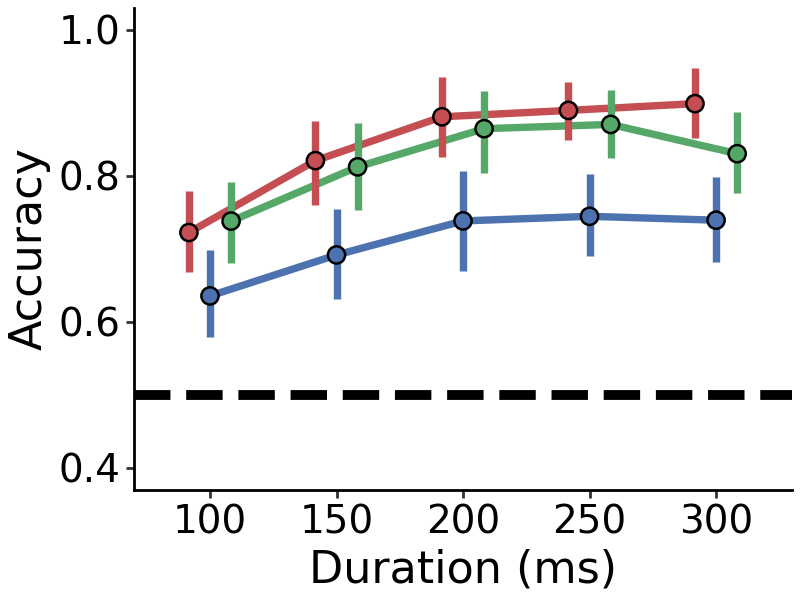


complete


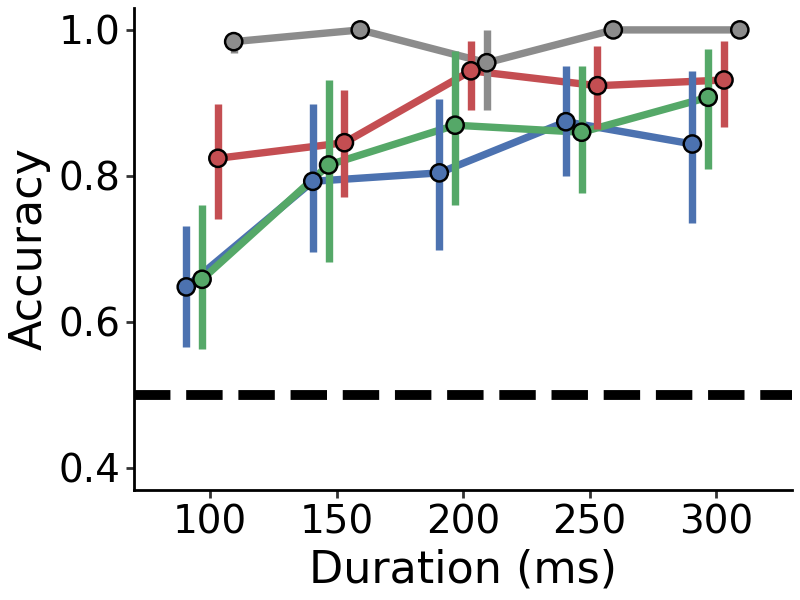


perturbed


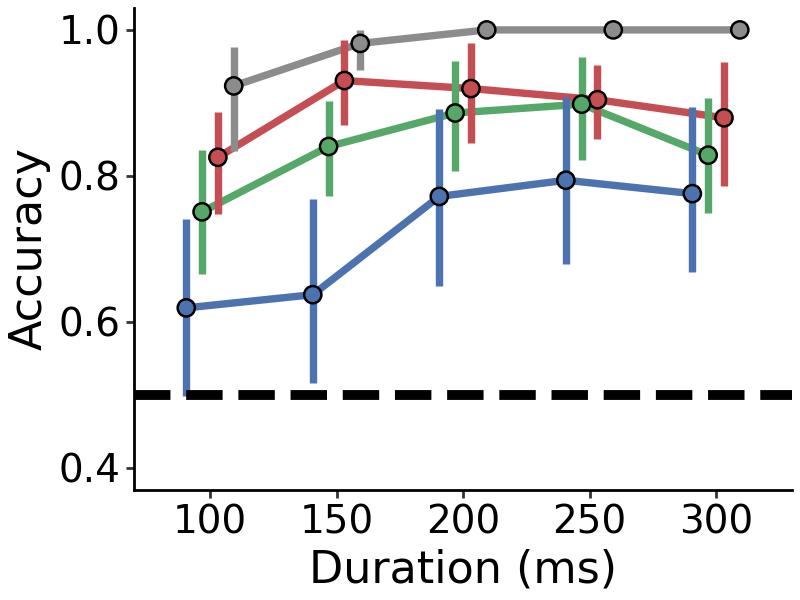


deleted


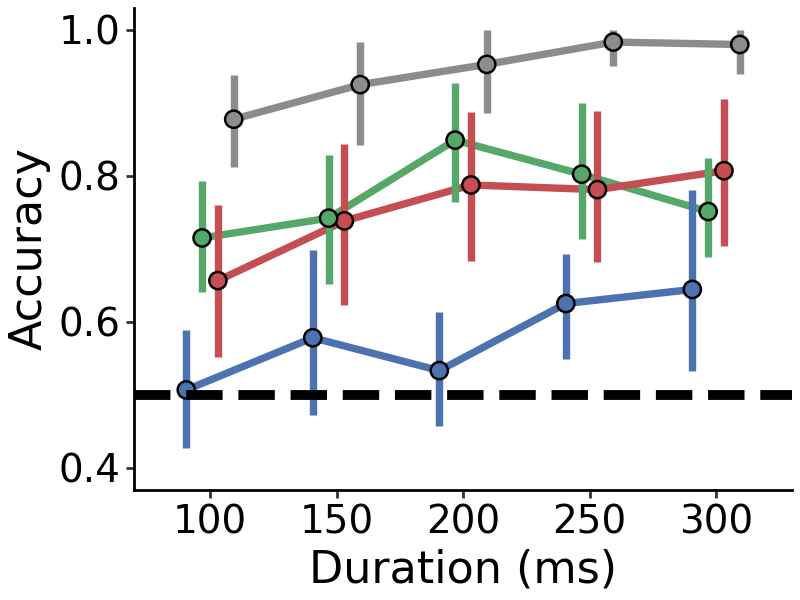

In [11]:
#load data
sub_summary = pd.read_csv(f'{results_dir}/group_data/sub_summary_long.csv')
#remove .35 duration
sub_summary = sub_summary[sub_summary['duration'] != .35]
#replace duration with duration label
sub_summary['duration'] = sub_summary['duration'].replace({.3:300, .25:250, .2:200, .15:150, .1:100})
#make duration integers
sub_summary['duration'] = sub_summary['duration'].astype(int)

#load adult data
sub_summary_adult = pd.read_csv(f'{results_dir}/group_data/sub_summary_adult.csv')

#replace duration with duration label
sub_summary_adult['duration'] = sub_summary_adult['duration'].replace({.3:300, .25:250, .2:200, .15:150, .1:100})
#make duration integers
sub_summary_adult['duration'] = sub_summary_adult['duration'].astype(int)





print('Summary by condition')
colors = [all_colors_hex[3],all_colors_hex[0],all_colors_hex[2]]
make_line_plot(sub_summary,'cond','summary_by_condition', colors)


#append adult data to sub_summary
sub_summary = pd.concat([sub_summary, sub_summary_adult], axis = 0)


#loop through conds and make line plots
for cond in conds:
    print(cond)
    kid_colors = [all_colors_hex[0],all_colors_hex[2],all_colors_hex[3],all_colors_hex[7]]
    sub_summary_cond = sub_summary[sub_summary['cond'] == cond]
    make_line_plot(sub_summary_cond,'age_group', f'{cond}_by_age_group',kid_colors)






## Model analyses

In [4]:
''' model params'''


model_arch = ['vonenet_ff_ecoset','vonenet_ff_stylized-ecoset','vonenet_r_ecoset','vonenet_r_stylized-ecoset', 'ShapeNet','SayCam','convnext', 'vit']
model_arch = ['vonenet_ff_ecoset','vonenet_ff_stylized-ecoset','vonenet_r_ecoset','vonenet_r_stylized-ecoset', 'twostream_ff', 'twostream_r','clip', 'cvcl','convnext', 'vit']
model_arch = ['vonenet_ff_ecoset','vonenet_ff_stylized-ecoset','vonenet_r_ecoset','vonenet_r_stylized-ecoset', 'twostream_ff', 'twostream_r','cvcl','clip_resnet','clip', 'convnext', 'vit']
model_arch = ['vonenet_ff_ecoset','vonenet_ff_stylized-ecoset','vonenet_r_ecoset','vonenet_r_stylized-ecoset', 'resnet50', 'resnet50_21k','cvcl','clip_resnet','clip_vit', 'convnext', 'vit','vit_21k']
model_arch = ['vonenet_ff_ecoset','vonenet_ff_stylized-ecoset','vonenet_r_ecoset','vonenet_r_stylized-ecoset', 'resnet50', 'resnet50_21k','clip_resnet_15m', 'clip_resnet_12m','clip_resnet','clip_vit', 'convnext', 'vit','vit_21k']

#models for first model fig
model_arch = ['vonenet_ff_ecoset','vonenet_ff_stylized-ecoset','vonenet_r_ecoset','vonenet_r_stylized-ecoset', 
              'SayCam', 'cvcl',
                'convnext', 'vit', 'clip_vit',
                'resnet50', 'resnet50_21k','clip_resnet_15m', 'clip_resnet']
model_names = ['VoneNet_FF-EcoSet', 'VoneNet_FF-EcoSet-Style', 'VoneNet_R-EcoSet', 'VoneNet_R-EcoSet-Style', 
               'ResNext50_SAY', 'CVCL',
               'ConvNext-ImageNet1k', 'ViT-ImageNet1k', 'ViT-CLIP',
               'ResNet50-ImageNet1k', 'ResNet50-ImageNet21k','ResNet50-YFCC15m', 'ResNet50-CLIP']
#create a list with 9 1s and 4 2
fig_order = [1,1,1,1,1,1,1,1,1,2,2,2,2,2,2]


human_vars = ['3yrold_fast','3yrold_slow','4yrold_fast','4yrold_slow','5yrold_fast','5yrold_slow', 'adult_fast','adult_slow']
human_labels = ['3yrold-fast','3yrold-slow','4yrold-fast','4yrold-slow','5yrold-fast','5yrold-slow', 'Adult-fast','Adult-slow']




model_conds = ['Outline','Pert','IC']


suf ='_all'
'''
model_colors = sns.light_palette(all_colors_hex[1],3)[-2:] +  sns.light_palette(all_colors_hex[4],3)[-2:] + \
    sns.light_palette(all_colors_hex[8],3)[-2:] + sns.light_palette(all_colors_hex[6],3)[-1:] + \
    sns.light_palette(all_colors_hex[0],3)[-2:] + sns.light_palette(all_colors_hex[2],3)[-2:] + \
    sns.light_palette(all_colors_hex[3],3)[-2:] + sns.light_palette(all_colors_hex[7],3)[-2:] 

model_colors = sns.light_palette(all_colors_hex[1],3)[-2:] +  sns.light_palette(all_colors_hex[4],3)[-2:] + \
    sns.light_palette(all_colors_hex[8],3)[-2:] + sns.light_palette(all_colors_hex[6],3)[-2:] + \
    sns.light_palette(all_colors_hex[3],6)[-6:] + sns.light_palette(all_colors_hex[7],3)[-2:] 
'''
model_colors = sns.light_palette("steelblue", 6)[-4:]  + sns.light_palette("seagreen", 3)[-2:] + \
    sns.light_palette("gold", 5)[-2:] + sns.light_palette("orange", 5)[-2:] + \
    sns.light_palette("violet", 5)[-1:] + sns.light_palette("purple", 5)[-2:] + \
        sns.light_palette("firebrick", 10)[-6:] + sns.light_palette("dimgray", 3)[-2:]

model_colors = sns.light_palette("steelblue", 6)[-4:]  + sns.light_palette("seagreen", 3)[-2:] + \
    sns.light_palette("gold", 5)[-1:] + sns.light_palette("orange", 5)[-2:] + \
        sns.light_palette("firebrick", 10)[-6:] + sns.light_palette("dimgray", 3)[-2:]


#model_colors = sns.color_palette(model_colors).as_hex()
#model_arch = ['vonenet_r_ecoset','vonenet_r_stylized-ecoset','vonenet_ff_ecoset','vonenet_ff_stylized-ecoset', 'ShapeNet','SayCam','convnext']
classifiers = ['SVM', 'Ridge', 'NB', 'KNN', 'logistic', 'NC']
train_ns = [5, 10, 25, 50, 100, 150, 200, 250, 300]


#load data
sub_summary = pd.read_csv(f'{results_dir}/group_data/sub_summary_long.csv')

#load adult data
sub_summary_adult = pd.read_csv(f'{results_dir}/group_data/sub_summary_adult.csv')
#combine
sub_summary = pd.concat([sub_summary, sub_summary_adult], axis = 0)


#remove .35 duration
sub_summary = sub_summary[sub_summary['duration'] < .3]


#train_ns = [5, 10]

#### Best performing models

In [5]:
'''Calculate boostrap CIs'''
#timeit
def compute_cis(df, iter = 10000):

    
    #initialize empty df
    boot_acc = []
    for i in range(0,iter):
        #sample with replacement
        df_boot = df.sample(n = len(df), replace = True)

        #calculate mean of acc
        acc = df_boot['acc'].mean()

        boot_acc.append(acc)

    #calculate 95% CI
    ci = np.percentile(boot_acc, [2.5, 97.5])

    return ci[0], ci[1]


     

In [22]:
'''
Determine best performing version of each model and then compare across models and children
'''



for cond in model_conds:
    print(cond)
    full_summary = pd.DataFrame(columns = ['model','classifier','train_ims','condition','acc', 'ci_low', 'ci_high','fig_number'])    
    
    '''First add kids and adult data'''
    for age in age_groups:
        for speed in ['fast', 'slow']:
            #extract sub data for age, cond, and speed
            temp_sub_summary = sub_summary[(sub_summary['age_group']==age) & (sub_summary['cond']==conds[model_conds.index(cond)]) & (sub_summary['speed']==speed)]
            

            #calculate mean acc
            acc = temp_sub_summary.loc[temp_sub_summary['speed']==speed,'acc'].mean()


            ci_low, ci_high = compute_cis(temp_sub_summary)


            #compile data into list
            temp_df = [f'{age}_{speed}', '','',conds[model_conds.index(cond)], acc, ci_low, ci_high, 0]
            temp_summary = pd.DataFrame([temp_df], columns = full_summary.columns)

            #add fig_number to temp_summary
            #temp_summary['fig_number'] = 0
            #append ot full_summary
            full_summary = pd.concat([full_summary, temp_summary], axis = 0)


    '''Now add best model for each architecture'''
    for model in model_arch:
        model_df = pd.DataFrame(columns = ['model','classifier','train_ims','condition','acc','ci_low','ci_high'])
        for classifier in classifiers:
        

            for train_n in train_ns:
                
                    model_file = f'{results_dir}/models/{model}_{classifier}_train{train_n}_test{cond}.csv'
                    if os.path.exists(model_file):
                        temp_df = pd.read_csv(model_file)

                        #groupby 
                        temp_df_mean = temp_df.groupby(['model','classifier','train_ims','condition'])['acc'].mean().reset_index()

        

                        
                        
                        
                        model_df = pd.concat([model_df, temp_df_mean], axis = 0)
                    else:
                        print(f'no {model}_{classifier}_train{train_n}_test{cond}.csv')

        #find best variation of current model
        best_model = model_df[model_df['acc'] == model_df['acc'].max()]

        #if there are more than one best model, take the one with the fewest training images
        if len(best_model) > 1:
            best_model = best_model[best_model['train_ims'] == best_model['train_ims'].min()]

        #reload best model file
        model_file = f'{results_dir}/models/{best_model["model"].values[0]}_{best_model["classifier"].values[0]}_train{best_model["train_ims"].values[0]}_test{cond}.csv'
        best_model_data = pd.read_csv(model_file)

        #compute CIs
        ci_low, ci_high = compute_cis(best_model_data)

        #add CI to best_model
        best_model['ci_low'] = ci_low
        best_model['ci_high'] = ci_high

        
        #add fig_number to best_model
        best_model['fig_number'] = fig_order[model_arch.index(model)]
        #add best_model to full_summary
        full_summary = pd.concat([full_summary, best_model], axis = 0)


    #rename model names
    full_summary['model'] = full_summary['model'].replace(dict(zip(model_arch, model_names)))

    #rename human vars
    full_summary['model'] = full_summary['model'].replace(dict(zip(human_vars, human_labels)))
    

    #save
    full_summary.to_csv(f'{results_dir}/{cond}_model_comparison{suf}.csv', index = False)
                    




Outline
Pert
IC


#### Plot model bars

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Outline


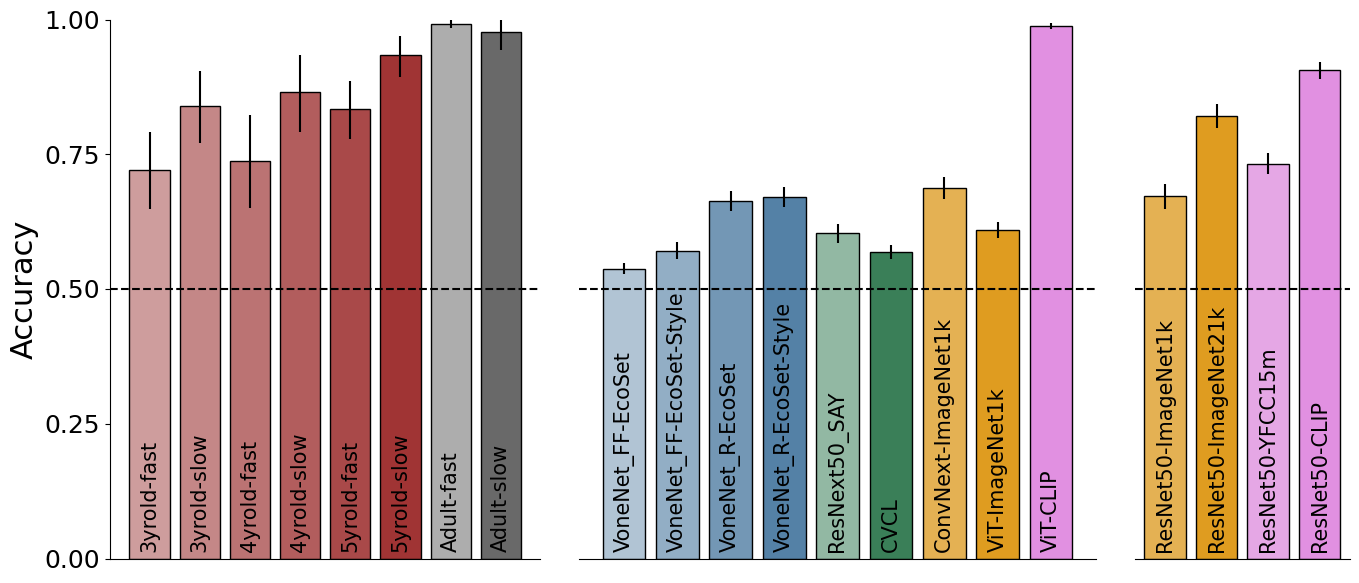

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pert


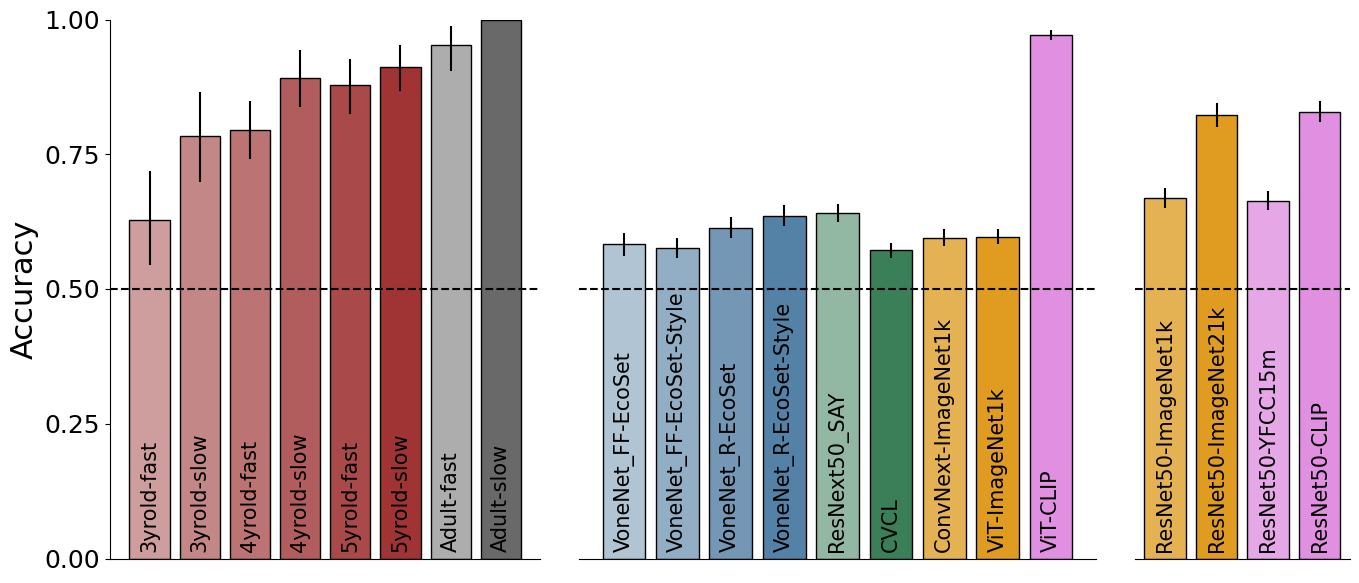

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


IC


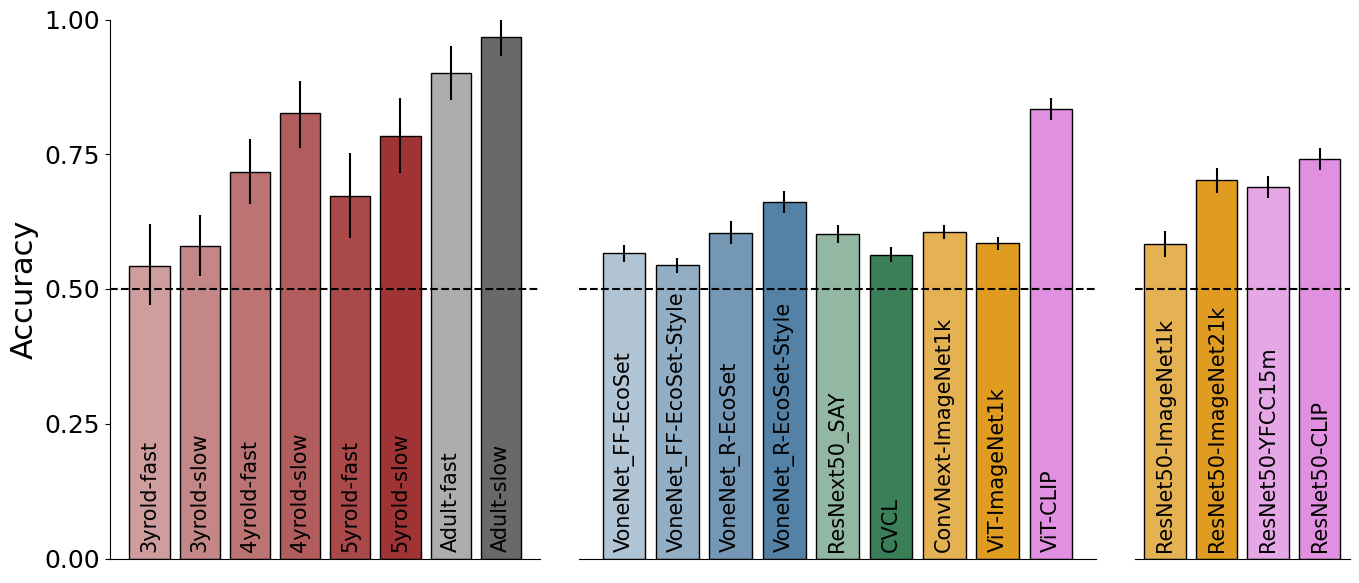

In [23]:
fig_sizes = [5.6, 6.3, 2.8]

model_colors = sns.light_palette("steelblue", 6)[-4:]  + sns.light_palette("seagreen", 3)[-2:] + \
    sns.light_palette("gold", 5)[-1:] + sns.light_palette("orange", 5)[-2:] + \
        sns.light_palette("firebrick", 10)[-6:] + sns.light_palette("dimgray", 3)[-2:]

model_colors = [sns.light_palette("firebrick", 10)[-6:] + sns.light_palette("dimgray", 3)[-2:],
                sns.light_palette("steelblue", 6)[-4:]  + sns.light_palette("seagreen", 3)[-2:] + sns.light_palette("orange", 5)[-2:] + sns.light_palette("violet", 5)[-1:],
                sns.light_palette("orange", 5)[-2:] + sns.light_palette("violet", 5)[-2:]]

for cond in model_conds:
    print(cond)

    all_organisms = pd.read_csv(f'{results_dir}/{cond}_model_comparison{suf}.csv')

    fig, ax = plt.subplots(1,3, figsize=(16,7), width_ratios=[1,1.2,.5],sharey=False)

    for panel in [0,1,2]:
        full_summary = all_organisms[all_organisms['fig_number'] == panel]
        



        #Make bar plot with each model as a different color, and CIs for error bars
        sns.barplot(data = full_summary, x = 'model', y = 'acc', hue = 'model', dodge=False, palette=model_colors[panel], edgecolor = 'k',ax=ax[panel])

        #add error bars

        ax[panel].errorbar(x = full_summary['model'], y = full_summary['acc'], yerr = [full_summary['acc'] - full_summary['ci_low'], full_summary['ci_high']-full_summary['acc']] , fmt = 'none', color = 'black', capsize = 0)

        #set y limits
        ax[panel].set_ylim([0,1])
        if panel == 0:
            ax[panel].set_ylabel('Accuracy', fontsize = 22)
            ax[panel].spines['left'].set_color('k')
            #increase font size of y axis labels
            #ax[panel].set_yticklabels(fontsize = 20)

            #set y-axis increments to .25
            ax[panel].set_yticks(np.arange(0, 1.25, .25))
            ax[panel].tick_params(axis='y', labelsize=18)
            

        else:
            pass
            #remove y label
            #ax[panel].set_ylabel('')
            
            #remove y ticks
            ax[panel].set_yticks([])
            #remove y tick labels
            ax[panel].set_yticklabels([])
            #remove y axis line
            ax[panel].spines['left'].set_visible(False)
            #remove y axis label
            #remove y axis label
            ax[panel].set_ylabel('')
            
            
        #remove tick labels
        
        ax[panel].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        
        
        
        
        #add dotted line at .5
        ax[panel].axhline(y=.5, color='black', linestyle='--')

        #remove x axis label
        #ax[panel].xlabel('')
            #remove x ticks and labels
        ax[panel].set_xticks([])
        ax[panel].set_xticklabels([])
        ax[panel].set_xlabel('')


        ax[panel].spines['bottom'].set_color('k')
    

        #remove top and right axes
        ax[panel].spines['top'].set_visible(False)
        ax[panel].spines['right'].set_visible(False)

        
        
        
        

        #remove top and right spines
        #sns.despine()

        #make left and bottom spines black
        #ax.spines['left'].set_color('black')

        #move labels inside bars
        for p, model_name in zip(ax[panel].patches, full_summary['model']):
            ax[panel].annotate(f'{model_name}', (p.get_x() + p.get_width() / 2., 0 ),
                        ha='center', va='bottom', fontsize=15, color='black', xytext=(0, 5), rotation = 90,
                        textcoords='offset points')
        
    

        #remove legend
        ax[panel].legend().remove()
        
    plt.subplots_adjust(wspace=.1, hspace=0)
    #save
    plt.savefig(f'{fig_dir}/{cond}_model_comparison{suf}.png', dpi = 300, bbox_inches = 'tight')
    
    plt.pause(.001)



## Line plots comparing conditions

In [7]:
'''Line plot comparing models across conditions'''

#load all cond files and append them
for cond in model_conds:
    print(cond)

    curr_cond = pd.read_csv(f'{results_dir}/{cond}_model_comparison{suf}.csv')

    #if first cond, create full_summary
    if cond == model_conds[0]:
        full_summary = curr_cond
    else:
        full_summary = pd.concat([full_summary, curr_cond], axis = 0)

    #rename Outline to Complete, Pert to Perturbed, and IC to Deleted
    full_summary['condition'] = full_summary['condition'].replace({'Outline':'Complete'})
    full_summary['condition'] = full_summary['condition'].replace({'Pert':'Perturbed'})
    full_summary['condition'] = full_summary['condition'].replace({'IC':'Deleted'})

    #capitalize condition
    full_summary['condition'] = full_summary['condition'].str.capitalize()





Outline
Pert
IC


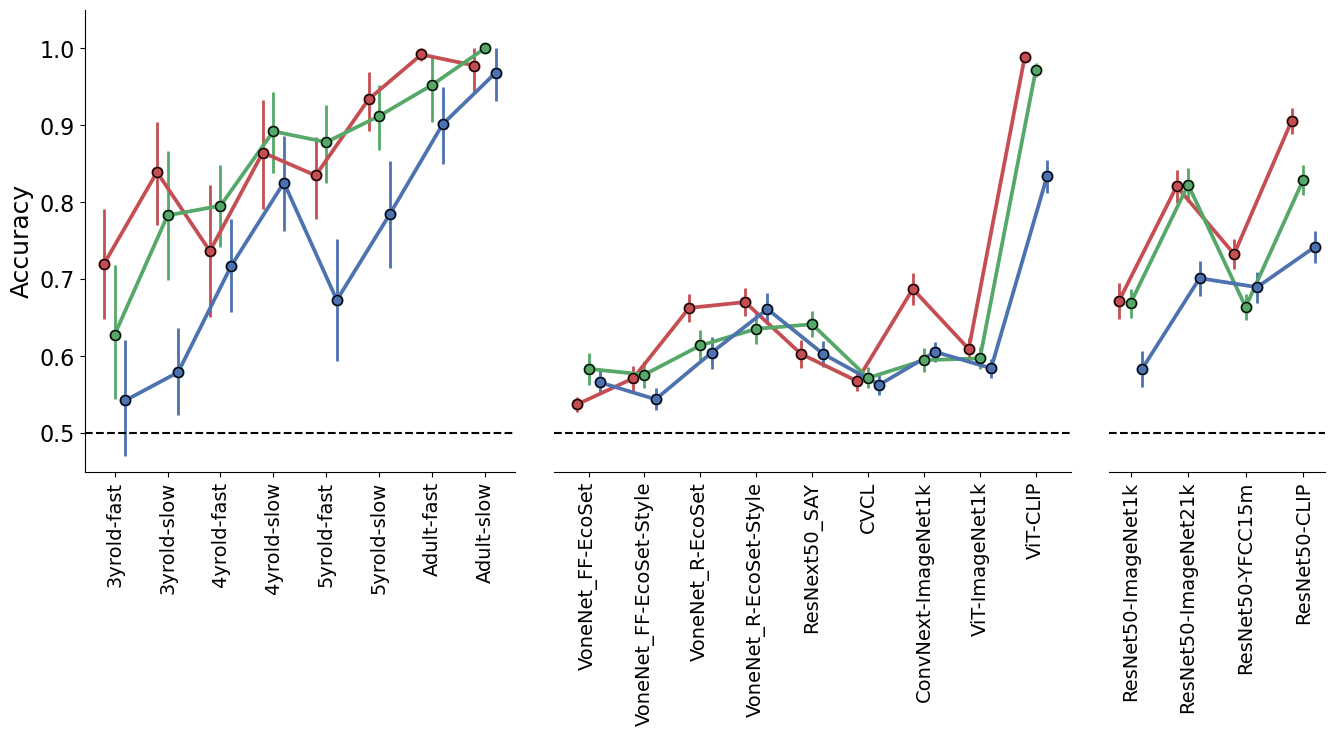

In [112]:
#creat line plot in seaborn with x = model, y = acc, hue = condition

colors = [all_colors_hex[3],all_colors_hex[2],all_colors_hex[0]]
fig_sizes = [5.6, 6.3, 2.8]
model_conds = ['Complete', 'Perturbed', 'Deleted']
offset = [-.2,0,.2]

fig, ax = plt.subplots(1,3, figsize=(16,6), width_ratios=[1,1.2,.5],sharey=False)

for panel in [0,1,2]:
    curr_panel = full_summary[full_summary['fig_number'] == panel]
    """ #create line plot
    sns.lineplot(data = curr_panel, x = 'model', y = 'acc', hue = 'condition', 
                 linewidth  = 3, palette = colors, ax=ax[panel],zorder = 0)

    #create dots on top of them 
    sns.scatterplot(data = curr_panel, x = 'model', y = 'acc', hue = 'condition', 
                    s = 40, edgecolor = 'k', palette = colors, ax=ax[panel],zorder = 2)
     """
    sns.pointplot(data = curr_panel, x = 'model', y = 'acc', hue = 'condition',
                  dodge = .4, palette = colors, ax=ax[panel])

    for cond in model_conds:
        curr_cond = curr_panel[curr_panel['condition'] == cond]
    
        ax[panel].errorbar(x = curr_cond['model'].reset_index().index + offset[model_conds.index(cond)], y = curr_cond['acc'], yerr = [curr_cond['acc'] - curr_cond['ci_low'], curr_cond['ci_high']-curr_cond['acc']] , 
            fmt = 'none', color = colors[model_conds.index(cond)], elinewidth = 2, capsize = 0, zorder = 0)
        ax[panel].scatter(curr_cond['model'].reset_index().index + offset[model_conds.index(cond)], curr_cond['acc'], color = colors[model_conds.index(cond)], s = 50, edgecolor = 'k', zorder = 3)

    #set y limits
    #ax[panel].set_ylim([.5,1.25])
    if panel == 0:
        ax[panel].set_ylabel('Accuracy', fontsize = 18)
        ax[panel].spines['left'].set_color('k')
        #increase font size of y axis labels
        #ax[panel].set_yticklabels(fontsize = 20)

        #set y-axis increments to .25
        ax[panel].set_yticks(np.arange(.5, 1.1, .1))
        ax[panel].tick_params(axis='y', labelsize=16)
        

    else:
        pass
        #remove y label
        #ax[panel].set_ylabel('')
        
        #remove y ticks
        ax[panel].set_yticks([])
        #remove y tick labels
        ax[panel].set_yticklabels([])
        #remove y axis line
        ax[panel].spines['left'].set_visible(False)
        #remove y axis label
        #remove y axis label
        ax[panel].set_ylabel('')
        
        
    #remove tick labels
    
    ax[panel].tick_params(axis='x',labelsize=14, rotation = 90)
    
    #remove legend
    ax[panel].legend().remove()
    
    
    #add dotted line at .5
    ax[panel].axhline(y=.5, color='black', linestyle='--')

    #remove x axis label
    #ax[panel].xlabel('')
        #remove x ticks and labels


    ax[panel].spines['bottom'].set_color('k')


    #remove top and right axes
    ax[panel].spines['top'].set_visible(False)
    ax[panel].spines['right'].set_visible(False)
    ax[panel].set_xlabel('')
    ax[panel].set_ylim([.45,1.05])
    plt.subplots_adjust(wspace=.1, hspace=0)

    #angle labels diagonally
    #ax[panel].xticks(rotation=90)
plt.show()

    
    



